# Finding total mols of H$_2$O in system
EQ3 always runs with 1 kg of solvent, i.e., H$_2$O present as unbound H$_2$O molecules. It therefore does not conserve the mass that we specify- but this is a requirement for using with the thermoengine equilibrate package. 

This notebook contains experiments in how to optimise this.

In [11]:
import pyQ3
import numpy as np
from scipy.optimize import root_scalar
import os
import matplotlib.pyplot as plt

Copied (and modified) from DEWFluid_module.py:

In [3]:
class Fluid(pyQ3.fluid.fluid):
    def __init__(self, system, t, p, n, fO2, total_mols_h2o=55.5):
        self.system = system
        self.T = t
        self.P = p
        self.pH = 5.0
        self.fO2 = fO2
        self.molalities, self.k = self._calc_basis_species_molalities(n, total_mols_h2o=total_mols_h2o)
        self.mineral_eq = {}
        self.solid_solutions = {}
        self.uebal = 'H+'
        self.uacion = ''
        self.nxmods = []
        self.dummy_temperature = 500.0

        eqpt_working_directory = 'eq_working'
        eq3_working_directory = 'eq_working'
        eqpt_executable_name = 'EQPT'
        eq3_executable_name = 'EQ3'
        input_filename = 'input'

        # If O2 is being set by mineral equilibrium:
        if 'O2(G)' in self.mineral_eq:
            self.fO2 = None

        # Create DATA0 and run EQPT
        # Determine filename automatically
        # if data0_filename is None and core.operatingsystem == 'Darwin':
        data0_filename = 'DATA0'
        # elif data0_filename is None and core.operatingsystem == 'Linux':
        #     data0_filename = 'data0'
        # Create the working directory if it doesn't exist:
        if not os.path.isdir(eqpt_working_directory):
            os.makedirs(eqpt_working_directory)
        # Create DATA0
        self.system.make_data0(self.T, self.P, format='pyQ3',
                               filepath=eqpt_working_directory + '/' + data0_filename,
                               dummy_temperature=self.dummy_temperature - 50)
        # Run EQPT
        pyQ3.core.run_eqpt(working_directory=eqpt_working_directory,
                           executable_name=eqpt_executable_name)

        # Create the eq3 working directory if it doesn't exist:
        if not os.path.isdir(eq3_working_directory):
            os.makedirs(eq3_working_directory)

        # Check to see if the working directories are different:
        if eq3_working_directory != eqpt_working_directory:
            os.system("cp " + eqpt_working_directory + '/data1 '
                      + eq3_working_directory + '/data1')

        # Create input file and run EQ3
        self._make_input(filepath=eq3_working_directory
                         + '/' + input_filename, format='pyQ3')
        pyQ3.core.run_eq3(working_directory=eq3_working_directory,
                          executable_name=eq3_executable_name)

        # Collect output
        self.eq3output = pyQ3.output.eq3output(
            filepath=eq3_working_directory + '/output')
        self.elemental_comp = self.eq3output.elemental_comp.set_index(
            'element').astype('float')
        # self.elemental_comp_ppm = dict(self.elemental_comp.ppm)
        self.elemental_comp_molality = dict(self.elemental_comp.molality)
        # self.pH = float(self.eq3output.electrochemistry['pH'][0])
        self.aqueous_species = self.eq3output.aqueous_species
        # self.fO2 = float(self.eq3output.redox['log_fO2'][0])
        # self.mineral_saturation = self.eq3output.mineral_saturation

    def _calc_basis_species_molalities(self, mols, total_mols_h2o=55.5):
        n = np.zeros(self.system.n_elements+1)
        n[:-1] = mols
        x = np.linalg.solve(self.system._basis_species_matrix.T, n)
        # EQ3 performs calculations assuming 1 kg of solvent, k will only be the correct scaling
        # if there is no additional H2O in complexes. May have to find k by iteration.
        k = total_mols_h2o/x[0]
        x = x*k
        molalities = {}
        for i, species in zip(range(len(self.system.basis_species)),
                              self.system.basis_species_names):
            if species != 'H+':
                molalities[species] = x[i]
        return molalities, k

    def _gibbs_energy(self):
        g = 0
        g += 55.5 * \
            self.system.species['H2O'].gibbs_energy(self.T, self.T)/self.k
        for i, row in self.aqueous_species.iterrows():
            if row.species != 'H+':
                g += (self.system.species[row.species].gibbs_energy(self.T, self.P)
                      + 8.314*self.T*np.log(row.activity))*row.molality/self.k
            else:
                g += (8.314*self.T*np.log(row.activity))*row.molality/self.k
        return g

Use a small demo system:

In [49]:
elements = ['O', 'H', 'Si', 'Na', 'Cl']
basis_species = ['H2O', 'H+', 'H4SIO4(AQ)', 'NA+', 'CL-', 'O2(G)']
other_species = ['H6SI2O7(AQ)', 'H8SI3O10(AQ)', 'H3SIO4-', 'OH-', 'O2(AQ)', 'NACL(AQ)']

In [50]:
system = pyQ3.System(basis_species=basis_species,
                     other_species=other_species,
                     elements=elements,
                     minerals=[],
                     gases=[],
                     hydrated_species={},
                     solid_solutions={})

In [86]:
moles = np.array([0.3 + 0.04, 
                  0.6 + 0.04, 
                  0.01,
                  0.0,
                  0.0
                 ])

Run the calculation with different values of H$_2$O moles:

In [87]:
h2o = np.linspace(55.0, 60.0, 5)
h2o_returned = np.zeros(np.shape(h2o))
for i in range(len(h2o)):
    fl = Fluid(system, 723.15, 10000.0, moles, -12.0, total_mols_h2o=h2o[i])
    h2o_returned[i] = fl.elemental_comp.molality['H']/2

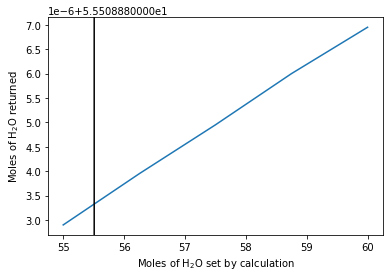

In [88]:
f, a = plt.subplots()
a.plot(h2o, h2o_returned)

a.set_xlim(a.get_xlim())
a.set_ylim(a.get_ylim())
a.plot(a.get_xlim(), a.get_xlim(), c='k')

a.set_xlabel('Moles of H$_2$O set by calculation')
a.set_ylabel('Moles of H$_2$O returned')

plt.show()

## Automate finding the correct value

In [62]:
def misfit(total_mols_h2o, system, n, t, p, fO2):
    fluid = Fluid(system, t, p, n, fO2, total_mols_h2o=total_mols_h2o)
    calcH2O = fluid.elemental_comp.molality['H']/2
    return calcH2O - total_mols_h2o

In [63]:
root_scalar(misfit, x0=55.5, x1=60.0, args=(system, moles, 723.15, 10000.0, -12.0))

      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 55.50888335

## Update custom Fluid class

In [124]:
class Fluid(pyQ3.fluid.fluid):
    def __init__(self, system, t, p, n, fO2):
        self.system = system
        self.T = t
        self.P = p
        self.pH = 5.0
        self.fO2 = fO2
        self.mineral_eq = {}
        self.solid_solutions = {}
        self.uebal = 'H+'
        self.uacion = ''
        self.nxmods = []
        self.dummy_temperature = 500.0
        
        self.eqpt_working_directory = 'eq_working'
        self.eq3_working_directory = 'eq_working'
        self.eqpt_executable_name = 'EQPT'
        self.eq3_executable_name = 'EQ3'
        self.input_filename = 'input'


        # Create DATA0 and run EQPT
        # Determine filename automatically
        # if data0_filename is None and core.operatingsystem == 'Darwin':
        data0_filename = 'DATA0'
        # elif data0_filename is None and core.operatingsystem == 'Linux':
        #     data0_filename = 'data0'
        # Create the working directory if it doesn't exist:
        if not os.path.isdir(self.eqpt_working_directory):
            os.makedirs(self.eqpt_working_directory)
        # Create DATA0
        self.system.make_data0(self.T, self.P, format='pyQ3',
                               filepath=self.eqpt_working_directory + '/' + data0_filename,
                               dummy_temperature=self.dummy_temperature - 50)
        # Run EQPT
        pyQ3.core.run_eqpt(working_directory=self.eqpt_working_directory,
                           executable_name=self.eqpt_executable_name)
        
        # Create the eq3 working directory if it doesn't exist:
        if not os.path.isdir(self.eq3_working_directory):
            os.makedirs(self.eq3_working_directory)

        # Check to see if the working directories are different:
        if self.eq3_working_directory != self.eqpt_working_directory:
            os.system("cp " + self.eqpt_working_directory + '/data1 '
                      + self.eq3_working_directory + '/data1')
        
        # EQ3 is then run during the mass conservation step.
        
        self._calc_basis_species_molalities(n)

        # Collect output (already started in mass balance step)
        # self.elemental_comp_ppm = dict(self.elemental_comp.ppm)
        self.elemental_comp_molality = dict(self.elemental_comp.molality)
        self.aqueous_species = self.eq3output.aqueous_species


    def _calc_basis_species_molalities(self, mols):
        # Don't need to store result as the calculation has already been performed.
        result = root_scalar(self._mass_misfit, x0=110, x1= 120, args=(mols))
        if result.converged is False:
            raise pyQ3.core.Error("Something went wrong in mass conservation.")
        
    def _gibbs_energy(self):
        g = 0
        g += 55.5 * \
            self.system.species['H2O'].gibbs_energy(self.T, self.T)/self.k
        for i, row in self.aqueous_species.iterrows():
            if row.species != 'H+':
                g += (self.system.species[row.species].gibbs_energy(self.T, self.P)
                      + 8.314*self.T*np.log(row.activity))*row.molality/self.k
            else:
                g += (8.314*self.T*np.log(row.activity))*row.molality/self.k
        return g
    
    def _element_projection(self, mols, total_mols_h):
        n = np.zeros(self.system.n_elements+1)
        n[:-1] = mols
        x = np.linalg.solve(self.system._basis_species_matrix.T, n)
        # x[0] is H2O
        k = total_mols_h/x[0]*2
        x = x*k
        molalities = {}
        for i, species in zip(range(len(self.system.basis_species)),
                              self.system.basis_species_names):
            if species not in ['H+', 'H2O', 'O2(G)'] and x[i] > 0:
                molalities[species] = x[i]
        return molalities, k
    
    def _mass_misfit(self, total_mols_h, mols):
        self.molalities, self.k = self._element_projection(mols, total_mols_h)
        
        # Create input file and run EQ3
        self._make_input(filepath=self.eq3_working_directory
                         + '/' + self.input_filename, format='pyQ3')
        pyQ3.core.run_eq3(working_directory=self.eq3_working_directory,
                          executable_name=self.eq3_executable_name)
        
        # Collect output
        self.eq3output = pyQ3.output.eq3output(
            filepath=self.eq3_working_directory + '/output')
        self.elemental_comp = self.eq3output.elemental_comp.set_index(
            'element').astype('float')
                
        calc_h = self.elemental_comp.molality['H']
        return calc_h - total_mols_h
        

In [125]:
fl = Fluid(system, 723.15, 10000.0, moles, -12.0)

In [126]:
fl.molalities

{'H4SIO4(AQ)': 6.938620194458031}